C:\Users\Techno\anaconda3\envs\geo\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Techno\anaconda3\envs\geo\lib\site-packages\numpy\lib\stride_tricks.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  array = np.array(array, copy=False, subok=subok)


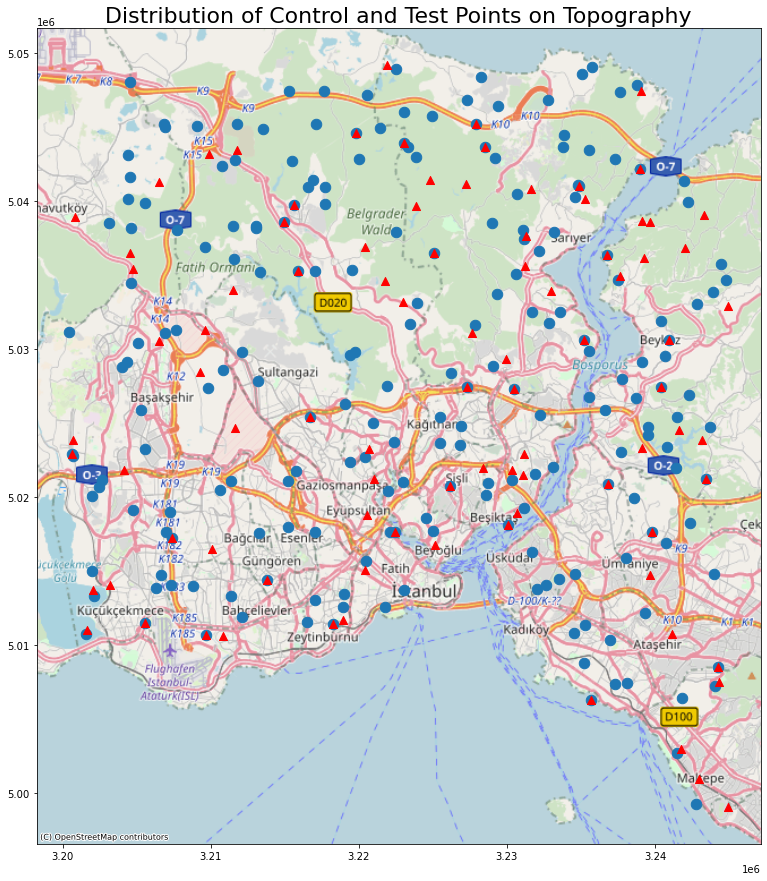

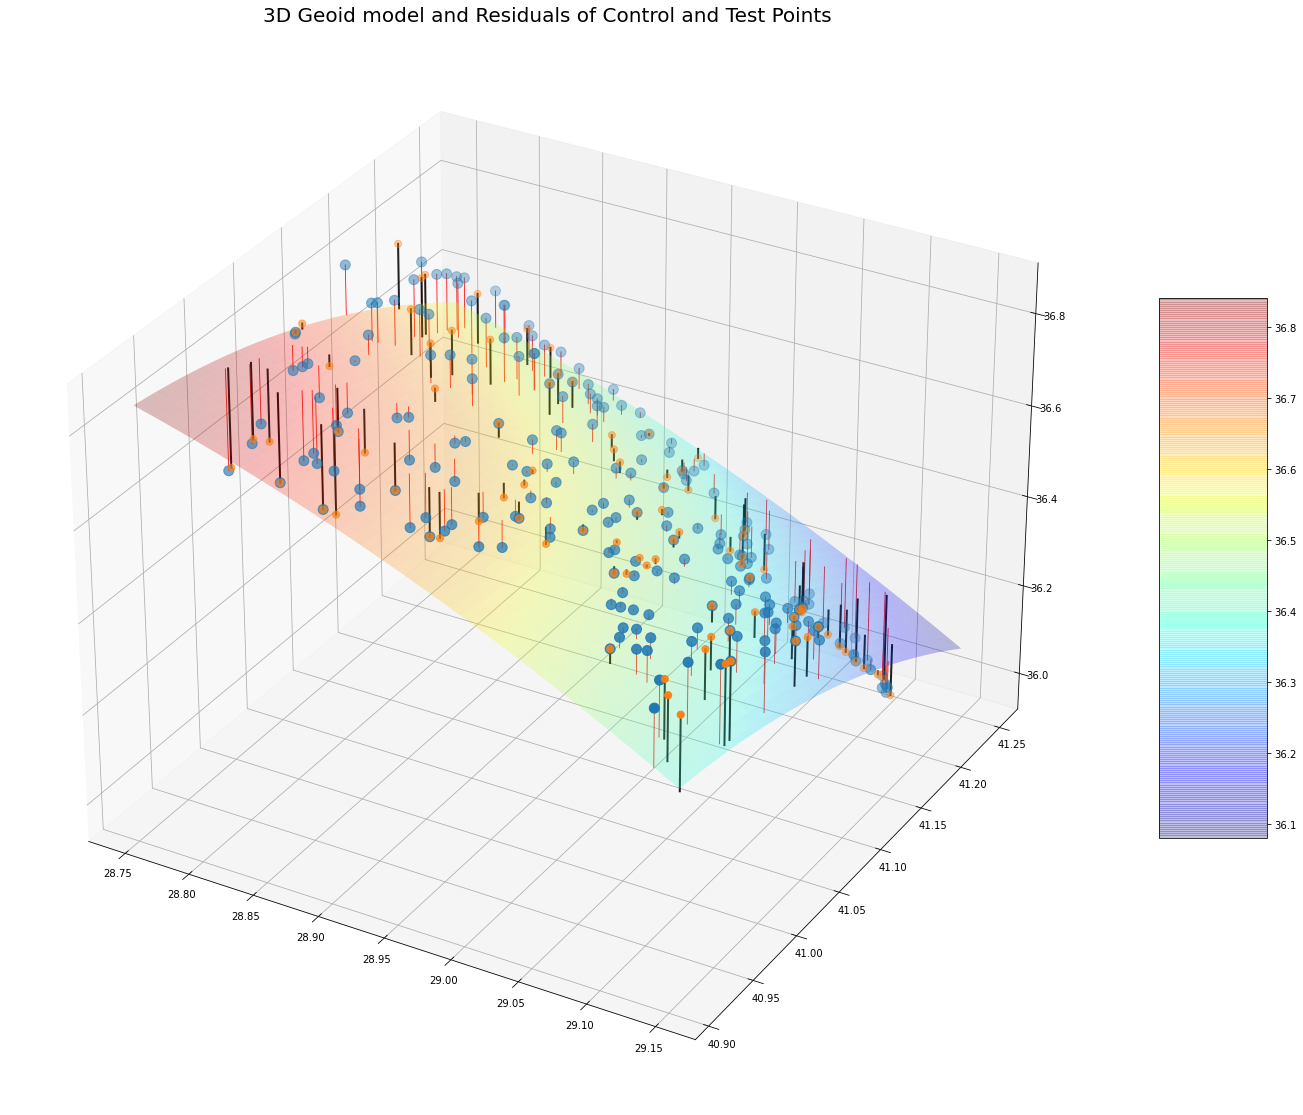

In [55]:
#importing required libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import os 
from sys import argv
import contextily as cxt
from matplotlib import cm
import matplotlib.pyplot as plt
from shapely.geometry import Point
from mpl_toolkits.mplot3d import Axes3D
#It is necessary to working on jupyter lab
%matplotlib inline 

#importing my data
c_point = pd.read_table("10160609_controlpoints_son.txt",names=["ID","Longitude","Latitude","H","h"])
t_point = pd.read_table("10160609_testpoints_son.txt",names=["ID","Longitude","Latitude","H","h"])
#calculating N value
c_point["N"] = c_point["h"]-c_point["H"]
t_point["N"] = t_point["h"]-t_point["H"]
#degree to radian convert
longitude = np.radians(c_point["Longitude"])
latitude = np.radians(c_point["Latitude"])
#calculating A matris
blank = []
for i in range (len(latitude)):
    row = [1,np.cos(latitude[i])*np.cos(longitude[i]),np.cos(latitude[i])*np.sin(longitude[i]),np.sin(latitude[i])]
    blank.append(row)
#if you want you can write to pc using below code
#"np.savetxt("A_matris.txt",A_matris)"
A_matris = np.array(blank).reshape(len(longitude),4)
#Normal equation solve -- 
AT_matris = np.transpose(A_matris).reshape(4,len(longitude))
l=np.array(c_point["N"]).reshape(len(longitude),1)
N = np.matmul(AT_matris,A_matris).reshape(4,4)
N_inverse = np.linalg.inv(N)
n = np.matmul(AT_martis,l)
x = np.matmul(N_inverse,n)
v = (np.matmul(A,x))-l
#Adjusted Measuremets
N_corrected = v+l
c_point["N_corrected"] = N_corrected
c_point ["Resudial"] = v
#For plotting base map
#For showing to points we have to convert to DataFrame
frame_control=pd.DataFrame(c_point) 
frame_test=pd.DataFrame(t_point)
#ITRF96 kod 8995 according to geopandas
crs= {'init': 'epsg:8995'} 
plot_control = [Point(xy) for xy in zip(frame_control["Longitude"],frame_control["Latitude"])] 
#For plotting points
plot_test = [Point(xy) for xy in zip(frame_test["Longitude"],frame_test["Latitude"])]
plot_frame_test = gpd.GeoDataFrame(frame_test,crs = crs,geometry = plot_test) 
#Data Frame to Convert Geo Data Frame
plot_frame_control = gpd.GeoDataFrame(frame_control,crs =crs,geometry=plot_control)
datum_control = plot_frame_control.to_crs(epsg=3857) 
#Geo Data Frame Coorditane to ITRF96
datum_test = plot_frame_test.to_crs(epsg = 3857)
ax = datum_control.plot(figsize = (15,15),marker = "o",markersize = 110) 
#Plotting the points to Surface
datum_test.plot(ax = ax,marker = "^",markersize = 65,color = "red")
cxt.add_basemap(ax,source=cxt.providers.OpenStreetMap.DE) 
#Adding Base Map to Background
ax.set_title("Distribution of Control and Test Points on Topography",fontsize=22)
#Also ypu can save the image using below code
#    "plt.savefig('title.png')"

#this part of code while writing Serkan Işık code was taken as a referenced 
# It is necessary to create 3D surface 
X_control = c_point["Longitude"] 
Y_control = c_point["Latitude"]
Z_control = c_point["N_corrected"]
#For Creating Surface Model
X_control_surface = np.linspace(X_control.min(),X_control.max(),100)
Y_control_surface = np.linspace(Y_control.min(),Y_control.max(),100)
X,Y = np.meshgrid(X_control_surface,Y_control_surface)
#It is my Adjusted Geoid model
new_geoid = x[0]+np.cos(np.radians(Y))*np.cos(np.radians(X))*x[1]+np.cos(np.radians(Y))*np.sin(np.radians(X))*x[2]+np.sin(np.radians(Y))*x[3] 
fig = plt.figure(figsize=(20,15))
ax = Axes3D(fig)
#Surface creating
surface = ax.plot_surface(X, Y, new_geoid, cmap=cm.jet, linewidth=0.1, alpha=0.25) 
#Layout 
fig.colorbar(surface, shrink=0.5, aspect=5) 
#Title 
ax.set_title("3D Geoid model and Residuals of Control and Test Points",size=20)
ax.scatter(X_control,Y_control,c_point["N"], s=100)
X_test = t_point["Longitude"]
Y_test = t_point["Latitude"]
Z_test = t_point["N"]
ax.scatter(X_test,Y_test,Z_test, s=50)
for i in range(len(X_control)):
    xc = [c_point["Longitude"][i], c_point["Longitude"][i]]
    yc = [c_point["Latitude"][i], c_point["Latitude"][i]]
    zc = [x[0]+np.cos(np.radians(Y_control[i]))*np.cos(np.radians(X_control[i]))*x[1]+np.cos(np.radians(Y_control[i]))*np.sin(np.radians(X_control[i]))*x[2]+np.sin(np.radians(Y_control[i]))*x[3], control["N"][i]]
    ax.plot(xc,yc,zc, "red", alpha=0.88, linewidth=0.88,)
dist = []
for i in range(len(X_test)):
    xt = [t_point["Longitude"][i], t_point["Longitude"][i]]
    yt = [t_point["Latitude"][i], t_point["Latitude"][i]]
    zt = [t_point["N"][i], x[0]+np.cos(np.radians(Y_test[i]))*np.cos(np.radians(X_test[i]))*x[1]+np.cos(np.radians(Y_test[i]))*np.sin(np.radians(X_test[i]))*x[2]+np.sin(np.radians(Y_test[i]))*x[3]]
    ax.plot(xt,yt,zt, "black", alpha=0.88, linewidth=2,)
    dist.append(zt)
#Also ypu can save the image using below code
#    "plt.savefig('title.png')"    

#Validation of Test Points 
validation = []
for i in range (len(dist)):
    valid = dist[i][1][0]-dist[i][0]
    validation.append(valid)

t_point["Resudial"] = validation
t_point.to_excel("Test_points.xlsx")
vt=np.transpose(v).reshape(1,len(v))
vv = np.matmul(vt,v)
mo = np.sqrt(vv/(len(v)-len(x)))
# " np.savetxt("mo.txt",mo) "